In [ ]:
import pandas as pd
import numpy as np
import logging
from pathlib import Path
from typing import Literal, Optional

import pandas as pd
from entities import EM_CDS_TRACKER_DICT, FX_TRACKER_DICT
from utils import Backtest, load_trackers, clean_stale_prices
from pathlib import Path
from aamalha.utils.performance import Performance

In [ ]:
fx = load_trackers(FX_TRACKER_DICT).rename(columns=lambda col: col + "_fx")
cds = load_trackers(EM_CDS_TRACKER_DICT).rename(columns=lambda col: col + "_cds")

trackers = pd.concat(
    [fx, cds],
    axis=1,
).fillna(method="ffill")
trackers = pd.concat(
    [clean_stale_prices(trackers[col].copy()) for col in trackers], axis=1
)
trackers = trackers[:"2024-09-30"]
trackers

In [ ]:
trackers.iloc[:, 0].shift(1)

In [ ]:
import statsmodels.api as sm

list_ccys = [
    "BRL",
    "CLP",
    "CNY",
    "COP",
    "IDR",
    "MXN",
    "MYR",
    "RUB",
    "TRY",
    "ZAR",
]
list_t_days = [
    # 1,
    # 5,
    # 21,
    # 63,
    # 126,
    252,
    # 252 * 2,
    # 252 * 3,
    # 252 * 5,
]

In [ ]:
model.


<bound method ResultsWrapper.load of <class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>>

In [216]:
list_results = []
for ccy in list_ccys:
    X = trackers[f"{ccy}_cds"].copy()
    Y = trackers[f"{ccy}_fx"].copy()
    X = np.log(X).diff(252).dropna()
    Y = np.log(Y).diff(21).dropna().shift(-21)

    new_index = X.dropna().index.intersection(Y.dropna().index)

    if not (Y.empty or new_index.empty):
        if len(Y.index) < 100:
            print(Y)
        X = X.reindex(new_index)
        Y = Y.reindex(new_index)
        X = sm.add_constant(X)

        model = sm.OLS(Y, X).fit()
        result = pd.Series(
            {
                "N": model.nobs,
                "Beta": model.params.iloc[1],
                "t": model.tvalues.iloc[1],
                "pvalue": model.pvalues.iloc[1],
                "r_squared": model.rsquared,
            },
            name=(ccy, 252),
        )
        list_results.append(result)

df_results = pd.concat(list_results, axis=1).T.reset_index(names=["Country", "T"])
df_results = df_results.sort_values("r_squared")
# df_results

pooled_X = []
pooled_Y = []

for ccy in list_ccys:
    X = trackers[f"{ccy}_cds"].copy()
    Y = trackers[f"{ccy}_fx"].copy()
    X = np.log(X).diff(252).dropna()
    Y = np.log(Y).diff(21).dropna().shift(-21)

    new_index = X.dropna().index.intersection(Y.dropna().index)

    if not (Y.empty or new_index.empty):
        X = X.reindex(new_index)
        Y = Y.reindex(new_index)
        pooled_X.append(X)
        pooled_Y.append(Y)

pooled_X = pd.concat(pooled_X)
pooled_Y = pd.concat(pooled_Y)
pooled_X = sm.add_constant(pooled_X)

pooled_model = sm.OLS(pooled_Y, pooled_X).fit()

pooled_result = pd.Series(
    {
        "N": pooled_model.nobs,
        "Beta": pooled_model.params.iloc[1],
        "t": pooled_model.tvalues.iloc[1],
        "pvalue": pooled_model.pvalues.iloc[1],
        "r_squared": pooled_model.rsquared,
    },
    name=("Pooled", 252),
)
df_aggregated = pd.concat(
    [df_results, pooled_result.to_frame().T.reset_index(names=["Country", "T"])]
)
df_aggregated.to_clipboard(excel=True, index=False)
df_aggregated

,Country,T,N,Beta,t,pvalue,r_squared
5,MXN,252,4037.0,0.010235,0.627142,5.306017e-01,0.000097
3,COP,252,4037.0,-0.037754,-2.310071,2.093445e-02,0.001321
9,ZAR,252,4037.0,-0.038293,-2.446230,1.447830e-02,0.001481
0,BRL,252,4037.0,-0.046963,-3.093755,1.989927e-03,0.002366
8,TRY,252,4037.0,-0.057625,-4.332775,1.508252e-05,0.004631
1,CLP,252,4037.0,-0.126543,-5.805482,6.911751e-09,0.008284
4,IDR,252,3060.0,-0.187303,-10.211381,4.276276e-24,0.032974
2,CNY,252,492.0,-0.299656,-5.575280,4.088400e-08,0.059652
7,RUB,252,3424.0,-0.157041,-15.249679,7.495468e-51,0.063634
6,MYR,252,470.0,-0.547603,-6.455873,2.695812e-10,0.081774


In [215]:
trackers["CNY_cds"].dropna()

date
2009-11-09     89.75
2009-11-10     89.77
2009-11-12     89.84
2009-11-13     89.81
2009-11-16     89.94
               ...  
2024-09-24    111.53
2024-09-25    111.56
2024-09-26    111.63
2024-09-27    111.62
2024-09-30    111.60
Name: CNY_cds, Length: 3742, dtype: float64

In [220]:
list_results = []
for ccy in list_ccys:
    cds = trackers[f"{ccy}_cds"].copy()
    fx = trackers[f"{ccy}_fx"].copy()
    cds_long_ret = np.log(cds).diff(252).dropna()
    fx_long_ret = np.log(fx).diff(252).dropna()
    beta = (
        fx_long_ret.ewm(halflife=252).cov(cds_long_ret)
        / cds_long_ret.ewm(halflife=252).var()
    ).dropna().iloc[100:]

    fx_short_ret = np.log(fx).diff(21).dropna()
    Y = fx_short_ret.shift(-21).dropna()
    X = (fx_long_ret - beta * cds_long_ret).dropna()
    new_index = X.dropna().index.intersection(Y.dropna().index)

    if not (Y.empty or new_index.empty):
        X = X.reindex(new_index)
        Y = Y.reindex(new_index)
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        result = pd.Series(
            {
                "N": model.nobs,
                "coef_beta": model.params.iloc[1],
                "t_beta": model.tvalues.iloc[1],
                "pvalue_beta": model.pvalues.iloc[1],
                "r_squared": model.rsquared,
            },
            name=(ccy, 252),
        )
        list_results.append(result)

df_results = pd.concat(list_results, axis=1).T.reset_index(names=["Country", "T"])
df_results = df_results.sort_values("r_squared")
# df_results

pooled_X = []
pooled_Y = []

for ccy in list_ccys:
    cds = trackers[f"{ccy}_cds"].copy()
    fx = trackers[f"{ccy}_fx"].copy()
    cds_long_ret = np.log(cds).diff(252).dropna()
    fx_long_ret = np.log(fx).diff(252).dropna()
    beta = (
        fx_long_ret.ewm(halflife=252).cov(cds_long_ret)
        / cds_long_ret.ewm(halflife=252).var()
    ).dropna().iloc[100:]
    

    fx_short_ret = np.log(fx).diff(21).dropna()
    Y = fx_short_ret.shift(-21).dropna()
    X = (fx_long_ret - beta * cds_long_ret).dropna()
    new_index = X.dropna().index.intersection(Y.dropna().index)

    if not (Y.empty or new_index.empty):
        X = X.reindex(new_index)
        Y = Y.reindex(new_index)
        pooled_X.append(X)
        pooled_Y.append(Y)

pooled_X = pd.concat(pooled_X)
pooled_Y = pd.concat(pooled_Y)
pooled_X = sm.add_constant(pooled_X)

pooled_model = sm.OLS(pooled_Y, pooled_X).fit()

pooled_result = pd.Series(
    {
        "N": pooled_model.nobs,
        "coef_beta": model.params.iloc[1],
        "t_beta": model.tvalues.iloc[1],
        "pvalue_beta": model.pvalues.iloc[1],
        "r_squared": pooled_model.rsquared,
    },
    name=("Pooled", 252),
)
df_aggregated = pd.concat(
    [df_results, pooled_result.to_frame().T.reset_index(names=["Country", "T"])]
)

df_aggregated.to_clipboard(excel=True, index=False)
df_aggregated

,Country,T,N,coef_beta,t_beta,pvalue_beta,r_squared
7,RUB,252,3323.0,0.003592,0.339133,7.345306e-01,0.000035
4,IDR,252,2959.0,-0.003665,-0.390581,6.961350e-01,0.000052
5,MXN,252,3936.0,0.013419,1.912778,5.584897e-02,0.000929
3,COP,252,3936.0,0.018675,2.326670,2.003338e-02,0.001374
1,CLP,252,3936.0,0.016946,2.437422,1.483643e-02,0.001508
9,ZAR,252,3936.0,0.030483,3.896147,9.936000e-05,0.003844
8,TRY,252,3936.0,-0.037813,-5.215005,1.932716e-07,0.006866
0,BRL,252,3936.0,0.032420,5.262783,1.494614e-07,0.006991
2,CNY,252,160.0,0.070104,7.374521,8.740752e-12,0.256063
6,MYR,252,149.0,0.270687,7.474391,6.427923e-12,0.275386


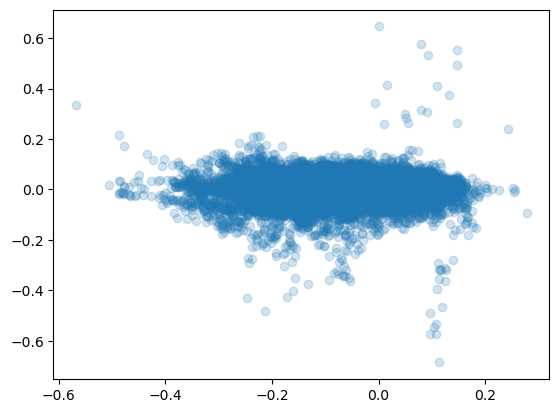

In [211]:
plt.scatter(pooled_X[0], pooled_Y, alpha=0.2)

# OLD

In [ ]:
import matplotlib.pyplot as plt 
pairs = [
    "BRL",
    "ZAR",
    # "CNY",
    "COP",
    # "IDR",
    "MXN",
    # "MYR",
    # "RUB",
    "CLP",
    "TRY",
]
N_DAYS = 21
HALFLIFE = 252

signals = {}
data = {}
for code in pairs:
    fx = trackers[f"{code}_fx"].copy()
    cds = trackers[f"{code}_cds"].copy()
    _index = fx.dropna().index.intersection(cds.dropna().index)
    fx = fx.reindex(_index)
    fx = fx / fx.iloc[0]
    cds = cds.reindex(_index)
    cds = cds / cds.iloc[0]
    fx = np.log(fx).diff(1).dropna()
    cds = np.log(cds).diff(1).dropna()
    beta = fx.ewm(halflife=HALFLIFE).cov(cds) / cds.ewm(halflife=HALFLIFE).var()
    beta = beta.iloc[HALFLIFE:].reindex(beta.index)
    actual_fx_returns = (np.exp(fx.rolling(HALFLIFE).sum()) - 1)
    expect_fx_returns = ((np.exp(cds.rolling(HALFLIFE).sum()) - 1) * beta)
    alpha = actual_fx_returns - expect_fx_returns
    actual_fx_returns.plot()
    expect_fx_returns.plot()
    alpha.plot()
    plt.title(code)
    plt.show()
    forward_return = np.exp(fx.rolling(21).sum()) - 1
    # signal = (alpha > 0).map({True: -1, False: 1}).shift(21) * forward_return
    # signals[code] = signal
    data[code] = (alpha, forward_return)

In [ ]:
df_signals = pd.concat(signals.values(), axis=1)
df_signals.columns = signals.keys()
df_signals.mean(axis=1).mean()

performar uma regress~ao dos sign("alpha") (exog) nos retornos de 1 mês
"forward_return" (endog),
sendo que temos timeseries desses dados e para 8 economias ("pairs") 


pairs = [
    "BRL",
    "ZAR",
    "CNY",
    "COP",
    "IDR",
    "MXN",
    "MYR",
    "RUB",
    "CLP",
    "TRY",
]

In [ ]:
sub_dfs = []
for code, (alpha, fwd_return) in data.items():
    # alpha = data["BRL"][0]
    alpha.name = "alpha"
    # fwd_return = data["BRL"][1]
    fwd_return.name = "fwd_return"
    base = pd.concat([alpha, fwd_return], axis=1)
    base["country"] = code
    # base = base.set_index("country", append=True)
    sub_dfs.append(base)  

base = pd.concat(sub_dfs)
base = base.dropna(how="any")
base["sign"] = (base["alpha"] > 0).map({True: -1, False: 1})
# base = base.drop("alpha", axis=1)
base

In [ ]:
# base.pivot(columns=["country"], values=["fwd_return", "sign"])#.dropna(how="any", axis=1)

In [ ]:
base

In [ ]:
import statsmodels.api as sm

X = base["alpha"]  # Variável independente
y = base["fwd_return"]  # Variável dependente

# Adicionar uma constante à variável independente para o intercepto
X = sm.add_constant(X)

# Ajustar o modelo de regressão
modelo = sm.OLS(y, X).fit()

# Exibir os resultados
print(modelo.summary())

In [ ]:
from linearmodels.panel import PanelOLS
base = base.reset_index()

modelo = PanelOLS(
    dependent=base[["fwd_return"]],
    exog=base[["sign"]],
    time_effects=True,
    entity_effects=True,
)


# # Especificar o modelo com efeitos fixos por entidade (country) e tempo
# modelo = PanelOLS.from_formula(
#     "fwd_return ~ sign + EntityEffects + TimeEffects", data=base
# )

# Ajustar o modelo
resultados = modelo.fit()

# Exibir os resultados
print(resultados.summary)